is this going to give me the same results as vs od death? probably yes

the challenge here is that all of the health data (weirdly, with the exception of overdose deaths) is aggregated over at least a quarter (i.e. 3 months), usually over years. the health data has ok spatial granularity by census tract, but the air quality data is only single points.

so now I'm grasping at straws and seeing if I can use arrest data as a proxy for brains doing weird stuff
probably not! but I want to see anyway

this data has exact timestamps, so could use hourly air quality data

In [52]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from air_brain.util.air import daily_pm25
from air_brain.data.get_data import DATA_DIR

arrest_file_name = os.path.join(DATA_DIR, "arrest.csv")

## arrest data

In [2]:
arrest_df = pd.read_csv(arrest_file_name)
arrest_df.ARRESTTIME = pd.to_datetime(arrest_df.ARRESTTIME)
print(len(arrest_df))
arrest_df.head(1)

66483


,_id,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1,1975272,16158872,42.0,F,B,2016-08-24 12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551


In [3]:
# what if we just look at assaults (simple 2701, aggravated 2702)
# this is a quick measure of "this person was arrested for a charge related to violence directed against another person"
assaults = arrest_df.loc[arrest_df.OFFENSES.astype(str).str.contains('2701|2702')].copy()
print(len(assaults))

17968


In [4]:
# this data has exact timestamps, and we do have hourly air quality data available
# however, for a quick picture, start with daily average
# even if there is an effect, I'd except a time lag anyway, right?
assaults['date'] = pd.to_datetime(assaults.ARRESTTIME.dt.date)
daily_assaults = assaults.groupby('date').agg({'OFFENSES': 'count'}).reset_index()

## combine with air quality

In [40]:
pm25 = daily_pm25()
df = daily_assaults.merge(pm25, on='date', how='outer', validate='1:1')

<Axes: xlabel='date'>

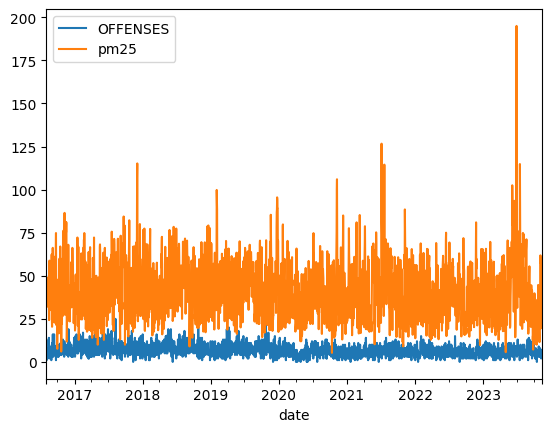

In [46]:
# restrict to date range where both have data
# do this twice because arrest record has early stretch of inconsistent data
df = df.loc[(df.date >= pm25.date.min()) & (df.date <= daily_assaults.date.max())]
df = df.loc[df.date >= '8/1/2016'] # this is when the arrest data actually seems to start

# a few days with no assault arrests
df.OFFENSES = df.OFFENSES.fillna(0)

df.plot(x='date', y=['OFFENSES', 'pm25'])

<Axes: >

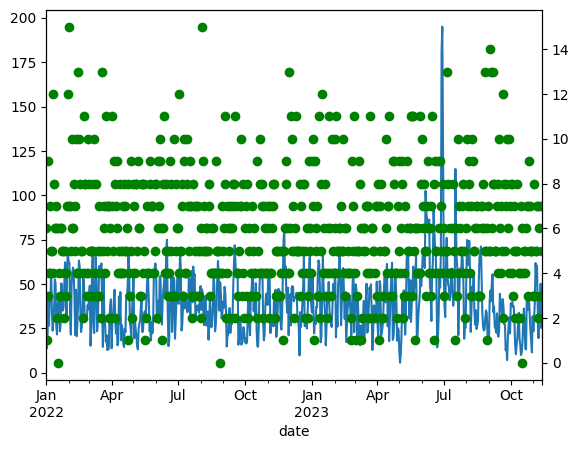

In [55]:
# zoom in on that spike in 2023
# ... yup, really doesn't look like there's anything there
zoom = df.loc[df.date >= '1/1/2022']
zoom = zoom.set_index('date')

plt.figure()
zoom.pm25.plot()
zoom.OFFENSES.plot(secondary_y=True, style='og')

<Axes: xlabel='pm25'>

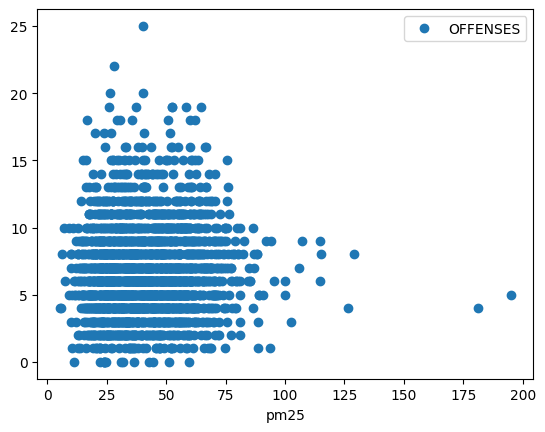

In [47]:
df.plot(x='pm25', y='OFFENSES', style='o')

In [48]:
df.corr()

,date,OFFENSES,pm25
date,1.000000,-0.281126,-0.074541
OFFENSES,-0.281126,1.000000,0.042226
pm25,-0.074541,0.042226,1.000000
